# Molecular D-HNN — Chapter 1: Normal Mode Latent Dynamics

**Goal:** Learn interpretable molecular dynamics by projecting into normal-mode coordinates and modelling the latent evolution with a Dissipative Hamiltonian Neural Network.

**Pipeline:**  rMD17 → SchNet (differentiable potential) → Hessian → Normal Modes → D-HNN dynamics

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, sys

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))

from dhnn.molecular.datasets import get_rmd17, RMD17_MOLECULES
from dhnn.molecular.copresheaf import CopresheafHamiltonian
from dhnn.molecular.training_mol import train_schnet
from dhnn.molecular.normal_modes import (
    normal_mode_analysis, project_to_modes, project_from_modes,
)
from dhnn.plotting import thesis_viridial, C

plt.style.use(os.path.join(os.path.dirname(os.getcwd()), "Thesis_style.mplstyle"))
torch.manual_seed(42)
np.random.seed(42)

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {DEVICE}")
print(f"Available molecules: {list(RMD17_MOLECULES.keys())}")

Device: mps
Available molecules: ['ethanol', 'aspirin', 'toluene', 'benzene', 'uracil', 'naphthalene', 'salicylic', 'malonaldehyde', 'paracetamol']


---
## 1. Data — rMD17 Ethanol

9 atoms (C₂H₅OH), 100 000 DFT configurations.  Following the standard rMD17 protocol we use 1 000 training samples.

In [2]:
splits = get_rmd17(
    "ethanol",
    n_train=1_000,
    n_val=1_000,
    cutoff=5.0,
    batch_size=32,
)

print(f"Molecule:   ethanol")
print(f"Atoms:      {splits.n_atoms}  (z = {splits.z.tolist()})")
print(f"Train:      {len(splits.train_loader.dataset)}")
print(f"Val:        {len(splits.val_loader.dataset)}")
print(f"Test:       {len(splits.test_loader.dataset)}")
print(f"E mean:     {splits.mean_energy:.2f} kcal/mol")
print(f"E std:      {splits.std_energy:.4f} kcal/mol")

Molecule:   ethanol
Atoms:      9  (z = [6, 6, 8, 1, 1, 1, 1, 1, 1])
Train:      1000
Val:        1000
Test:       553092
E mean:     -97195.78 kcal/mol
E std:      4.2403 kcal/mol


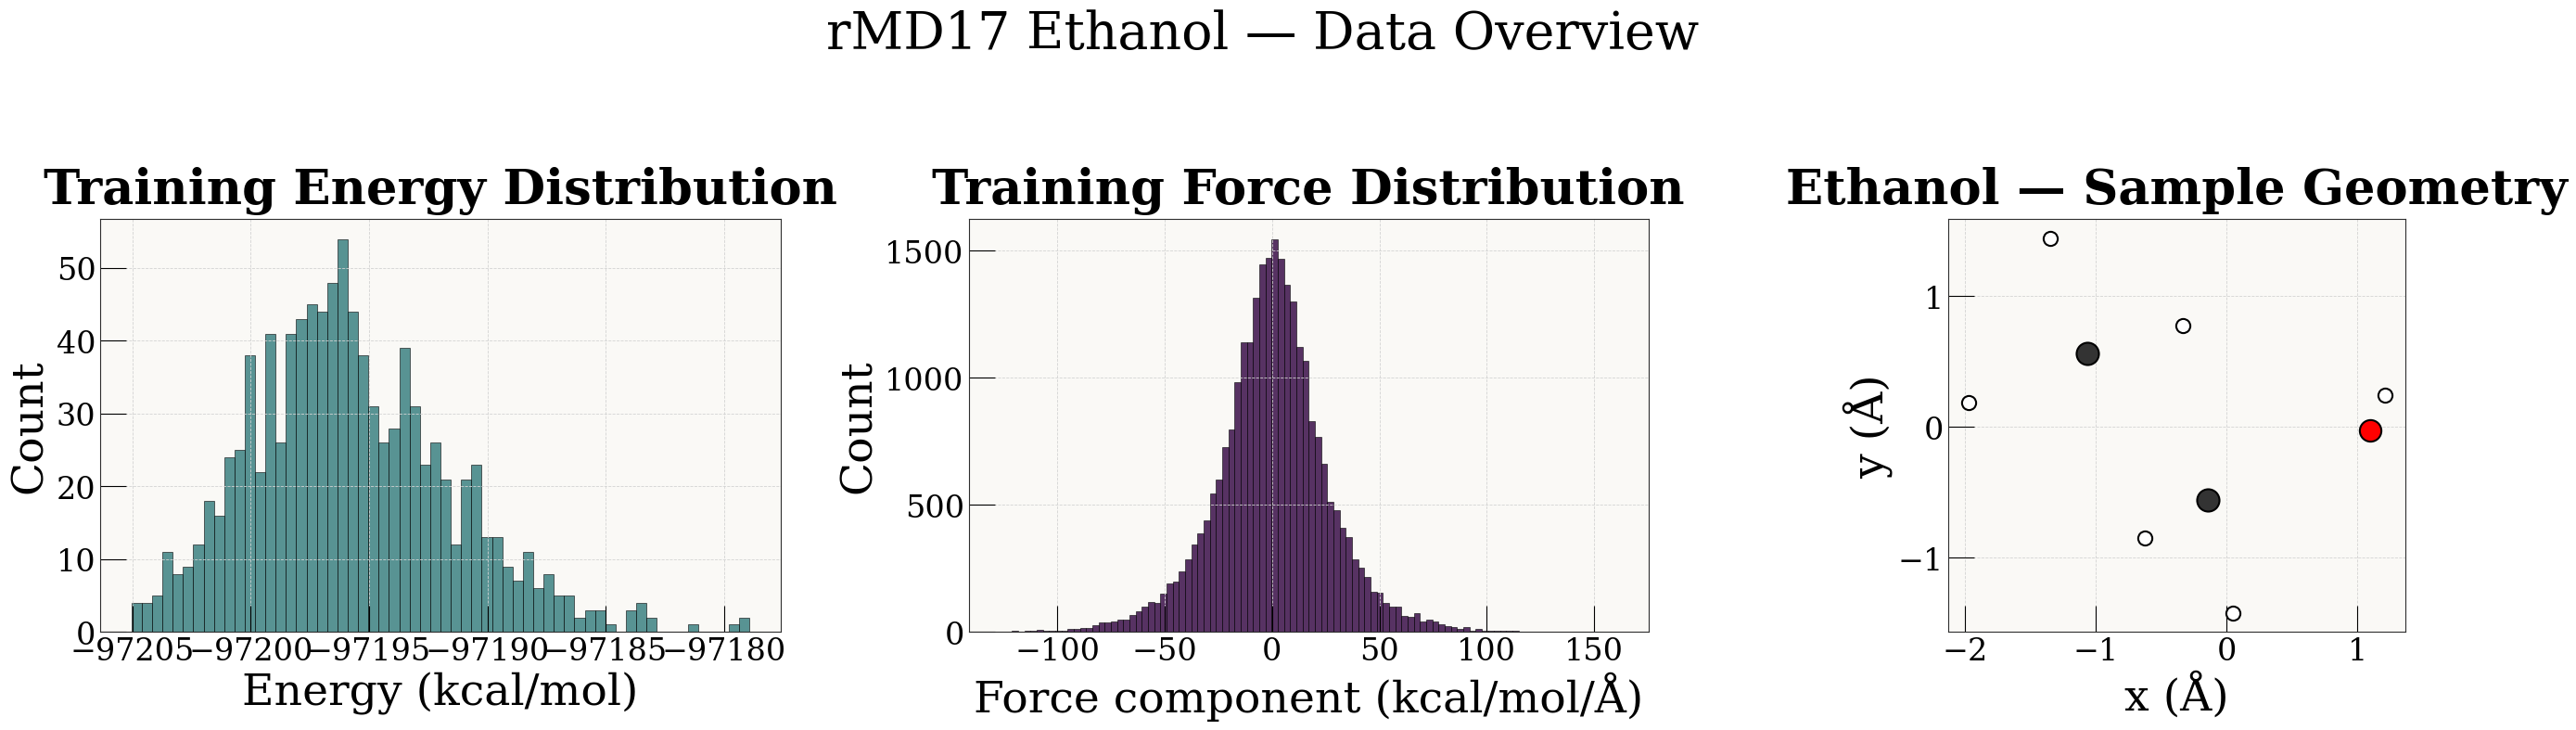

In [3]:
# ── Visualise data distributions ──────────────────────────────────
sample_batch = next(iter(splits.train_loader))
energies = [d.y.item() for d in splits.train_loader.dataset]
forces_flat = torch.cat([d.force.reshape(-1) for d in splits.train_loader.dataset])

fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# Energy distribution
axes[0].hist(energies, bins=60, color=C["dhnn"], alpha=0.8, edgecolor="k", lw=0.5)
axes[0].set_xlabel("Energy (kcal/mol)")
axes[0].set_ylabel("Count")
axes[0].set_title("Training Energy Distribution")

# Force distribution
axes[1].hist(forces_flat.numpy(), bins=100, color=C["hnn"], alpha=0.8, edgecolor="k", lw=0.5)
axes[1].set_xlabel("Force component (kcal/mol/Å)")
axes[1].set_ylabel("Count")
axes[1].set_title("Training Force Distribution")

# One molecular snapshot (3D scatter of first config)
d0 = splits.train_loader.dataset[0]
pos0 = d0.pos.numpy()
z0 = d0.z.numpy()
atom_colors = {1: "white", 6: "#333333", 8: "red", 7: "blue"}
atom_sizes  = {1: 120, 6: 300, 8: 280, 7: 280}
for iz in np.unique(z0):
    mask = z0 == iz
    axes[2].scatter(
        pos0[mask, 0], pos0[mask, 1],
        s=atom_sizes.get(iz, 200), c=atom_colors.get(iz, "grey"),
        edgecolors="k", linewidths=1.5, zorder=3,
    )
axes[2].set_xlabel("x (Å)"); axes[2].set_ylabel("y (Å)")
axes[2].set_title("Ethanol — Sample Geometry")
axes[2].set_aspect("equal")

fig.suptitle("rMD17 Ethanol — Data Overview", fontsize=40, y=1.02)
fig.tight_layout()
fig.savefig("../figures/mol_ethanol_data_overview.pdf", bbox_inches="tight", dpi=150)
plt.show()

---
## 2. Copresheaf Hamiltonian — Force Field Training

Train a **Copresheaf Neural Network** as a differentiable potential $V_\theta(\mathbf{z}, \mathbf{r})$.

The copresheaf assigns feature stalks to atoms and interaction stalks to edges.  Extension maps $\mathcal{F}_{v \to e}$ project atomic features into a shared stalk space, conditioned on interatomic distance.

Loss: $\mathcal{L} = 0.01 \cdot \text{MSE}(E) + \text{MSE}(\mathbf{F})$ — force-dominated following NequIP/MACE convention.

In [3]:
model = CopresheafHamiltonian(
    d_node=128,
    d_stalk=16,
    n_layers=6,
    n_rbf=50,
    cutoff=5.0,
    mean=splits.mean_energy,
    std=splits.std_energy,
)

n_params = sum(p.numel() for p in model.parameters())
print(f"CopresheafHamiltonian parameters: {n_params:,}")
print(f"  d_node={128}, d_stalk={16}, n_layers={6}")
print(f"Energy normalisation: μ={splits.mean_energy:.2f}, σ={splits.std_energy:.4f}")

CopresheafHamiltonian parameters: 296,929
  d_node=128, d_stalk=16, n_layers=6
Energy normalisation: μ=-97195.78, σ=4.2403


In [4]:
import os
ckpt = os.path.join(os.path.dirname(os.getcwd()), "checkpoints", "copresheaf_ethanol.pt")

if os.path.exists(ckpt):
    model.load_state_dict(torch.load(ckpt, weights_only=True))
    model = model.to(DEVICE)
    print(f"✓ Loaded checkpoint: {ckpt}")
    history = None  # skip training
else:
    history = train_schnet(
        model,
        splits.train_loader,
        splits.val_loader,
        epochs=300,
        lr=5e-4,
        energy_weight=0.01,
        device=DEVICE,
        patience=40,
        checkpoint_name="copresheaf_ethanol.pt",
    )

✓ Loaded checkpoint: /Users/aleksandersekkelsten/D_HNN/checkpoints/copresheaf_ethanol.pt


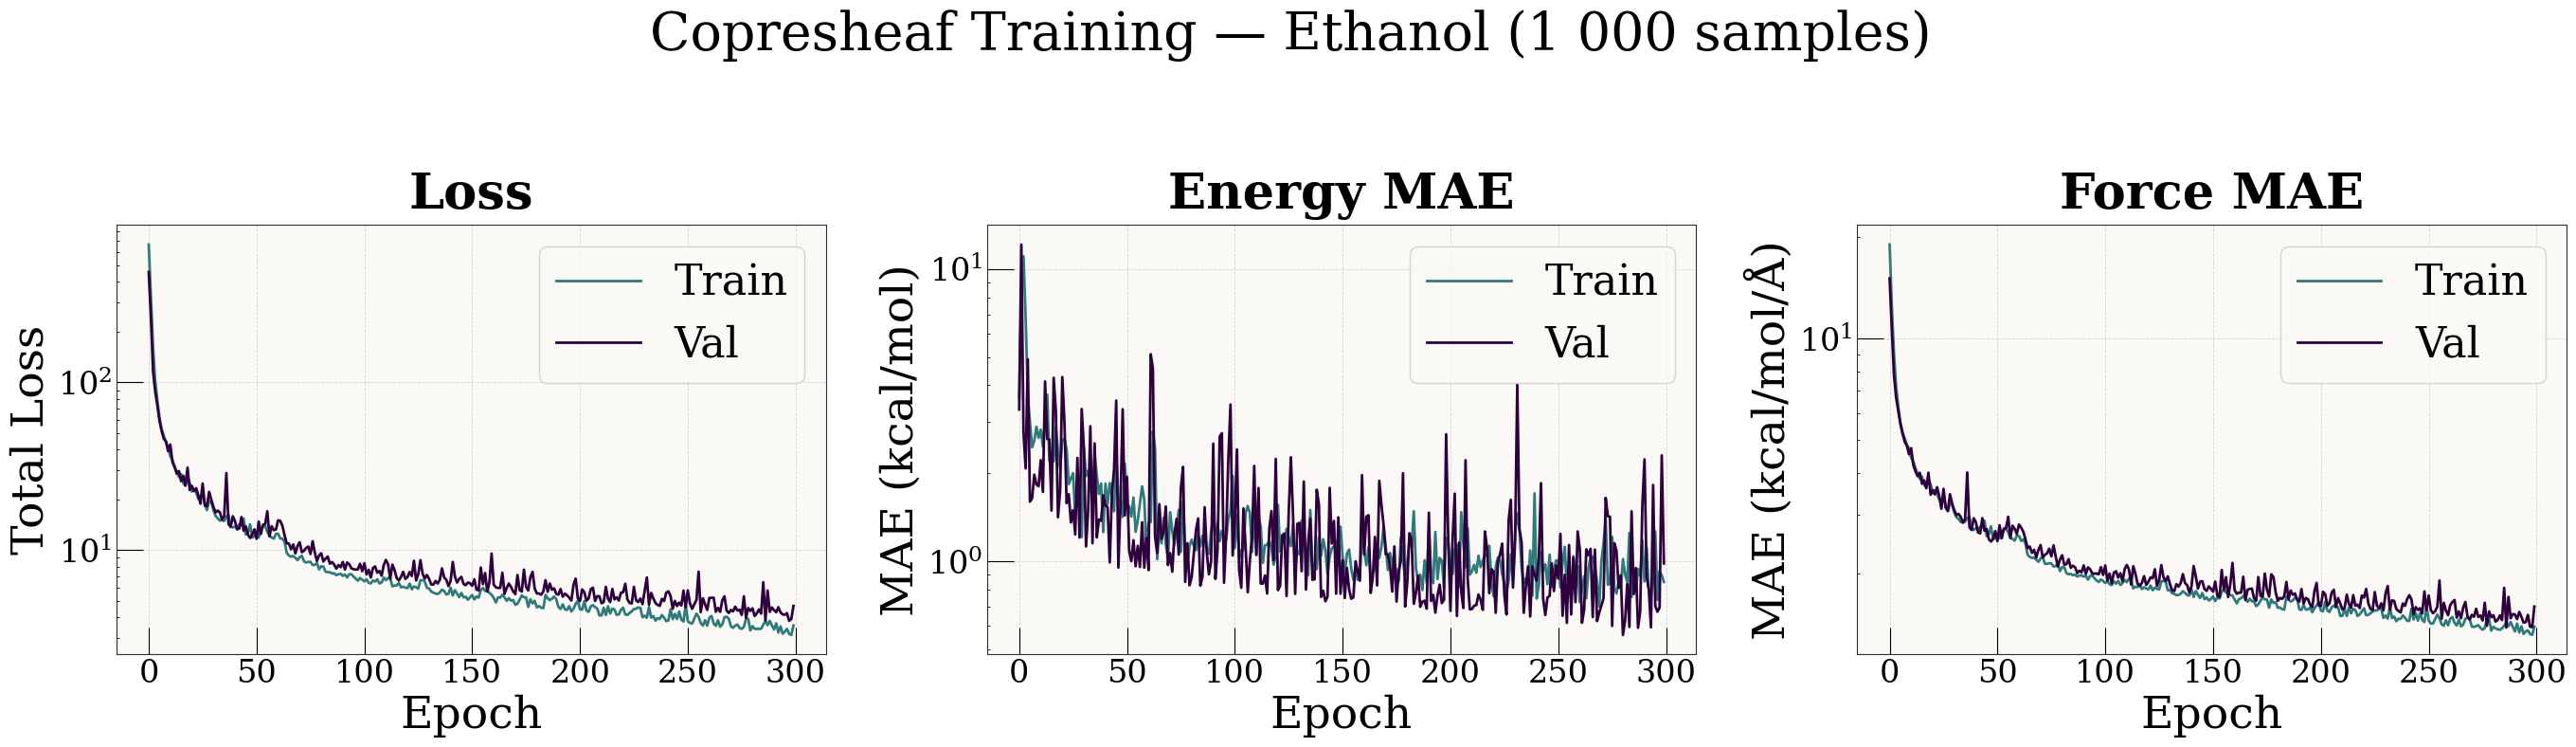

Final val  Energy MAE: 0.9824 kcal/mol
Final val  Force  MAE: 1.6010 kcal/mol/Å


In [ ]:
if history is not None:
    # ── Training curves ───────────────────────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(28, 8))

    axes[0].semilogy(history["train_loss"], label="Train", color=C["dhnn"], lw=2)
    axes[0].semilogy(history["val_loss"],   label="Val",   color=C["hnn"],  lw=2)
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Total Loss")
    axes[0].set_title("Loss"); axes[0].legend()

    axes[1].semilogy(history["train_energy_mae"], label="Train", color=C["dhnn"], lw=2)
    axes[1].semilogy(history["val_energy_mae"],   label="Val",   color=C["hnn"],  lw=2)
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("MAE (kcal/mol)")
    axes[1].set_title("Energy MAE"); axes[1].legend()

    axes[2].semilogy(history["train_force_mae"], label="Train", color=C["dhnn"], lw=2)
    axes[2].semilogy(history["val_force_mae"],   label="Val",   color=C["hnn"],  lw=2)
    axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("MAE (kcal/mol/Å)")
    axes[2].set_title("Force MAE"); axes[2].legend()

    fig.suptitle("Copresheaf Training — Ethanol (1 000 samples)", fontsize=40, y=1.02)
    fig.tight_layout()
    fig.savefig("../figures/mol_copresheaf_training.pdf", bbox_inches="tight", dpi=150)
    plt.show()

    print(f"Final val  Energy MAE: {history['val_energy_mae'][-1]:.4f} kcal/mol")
    print(f"Final val  Force  MAE: {history['val_force_mae'][-1]:.4f} kcal/mol/Å")
else:
    print("Loaded from checkpoint — training curves not available")

---
## 3. Normal Mode Analysis

Compute the Hessian $\partial^2 E / \partial r_i \partial r_j$ at the equilibrium geometry via autograd through the trained SchNet. Diagonalise the mass-weighted Hessian to obtain $3N - 6 = 21$ vibrational normal modes.

In [6]:
# Find equilibrium geometry (lowest energy in training set)
energies_all = torch.tensor([d.y.item() for d in splits.train_loader.dataset])
eq_idx = energies_all.argmin().item()
eq_data = splits.train_loader.dataset[eq_idx]
eq_pos = eq_data.pos
print(f"Equilibrium config index: {eq_idx}")
print(f"Equilibrium energy: {eq_data.y.item():.4f} kcal/mol")
print(f"Positions shape: {eq_pos.shape}")

Equilibrium config index: 424
Equilibrium energy: -97205.0469 kcal/mol
Positions shape: torch.Size([9, 3])


In [7]:
# Normal mode analysis via autograd Hessian
model_cpu = model.cpu()
nm_result = normal_mode_analysis(model_cpu, eq_data.z, eq_pos)

print(f"Number of internal modes: {len(nm_result.frequencies_cm1)}")
print(f"Expected (3N-6): {3 * splits.n_atoms - 6}")
print(f"\nVibrational frequencies (cm⁻¹):")
for i, freq in enumerate(nm_result.frequencies_cm1):
    print(f"  Mode {i+1:2d}: {freq:8.1f} cm⁻¹")

Number of internal modes: 27
Expected (3N-6): 21

Vibrational frequencies (cm⁻¹):
  Mode  1: -167970763864332.4 cm⁻¹
  Mode  2: -59470967850655.5 cm⁻¹
  Mode  3: -30229303310968.1 cm⁻¹
  Mode  4: 37907604141.4 cm⁻¹
  Mode  5: 66782654690.2 cm⁻¹
  Mode  6: 121933636175.4 cm⁻¹
  Mode  7: 326313869971604.0 cm⁻¹
  Mode  8: 343116040763762.3 cm⁻¹
  Mode  9: 382904698518967.8 cm⁻¹
  Mode 10: 588876017729907.5 cm⁻¹
  Mode 11: 682676027499003.5 cm⁻¹
  Mode 12: 840142693806094.9 cm⁻¹
  Mode 13: 878575944865006.0 cm⁻¹
  Mode 14: 885040333830222.4 cm⁻¹
  Mode 15: 971997445634863.1 cm⁻¹
  Mode 16: 1063716662969613.9 cm⁻¹
  Mode 17: 1090686663788075.9 cm⁻¹
  Mode 18: 1118125460363790.9 cm⁻¹
  Mode 19: 1139445516952318.0 cm⁻¹
  Mode 20: 1145474353491775.2 cm⁻¹
  Mode 21: 1187502182725841.5 cm⁻¹
  Mode 22: 2102279517726888.0 cm⁻¹
  Mode 23: 2274528021053408.0 cm⁻¹
  Mode 24: 2300383692491837.0 cm⁻¹
  Mode 25: 2329696043318387.0 cm⁻¹
  Mode 26: 2581243104196415.0 cm⁻¹
  Mode 27: 2715515370136896.5 cm⁻

In [ ]:
# ── Visualise normal mode spectrum ────────────────────────────────
fig, ax = plt.subplots(figsize=(20, 8))
freqs = nm_result.frequencies_cm1
colours = thesis_viridial(np.linspace(0, 1, len(freqs)))

ax.bar(range(1, len(freqs) + 1), freqs, color=colours, edgecolor="k", lw=0.8)
ax.set_xlabel("Mode index")
ax.set_ylabel("Frequency (cm$^{-1}$)")
ax.set_title("Ethanol — Normal Mode Frequencies")
ax.set_xticks(range(1, len(freqs) + 1))

fig.tight_layout()
fig.savefig("../figures/mol_normal_mode_spectrum.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [ ]:
# ── Project all training configs into normal mode coordinates ─────
all_positions = np.stack([d.pos.numpy() for d in splits.train_loader.dataset])  # [1000, 9, 3]
Q_all = project_to_modes(all_positions, nm_result)  # [1000, 21]

print(f"Normal mode coordinates shape: {Q_all.shape}")
print(f"Mode amplitude std:  {Q_all.std(axis=0).round(4)}")

# Reconstruction error
recon = project_from_modes(Q_all, nm_result)
rmsd = np.sqrt(((recon - all_positions) ** 2).mean())
print(f"\nReconstruction RMSD: {rmsd:.6f} Å")

In [ ]:
# ── Normal mode amplitude distributions ──────────────────────────
n_show = min(9, Q_all.shape[1])
fig, axes = plt.subplots(3, 3, figsize=(28, 20))

for i, ax in enumerate(axes.flat[:n_show]):
    ax.hist(Q_all[:, i], bins=50,
            color=thesis_viridial(i / max(n_show - 1, 1)),
            alpha=0.85, edgecolor="k", lw=0.5)
    ax.set_title(f"Mode {i+1}  ({freqs[i]:.0f} cm$^{{-1}}$)")
    ax.set_xlabel("$Q_k$")
    ax.set_ylabel("Count")

fig.suptitle("Normal Mode Amplitude Distributions (Training Set)",
             fontsize=40, y=1.01)
fig.tight_layout()
fig.savefig("../figures/mol_mode_distributions.pdf", bbox_inches="tight", dpi=150)
plt.show()

---
## 4. Normal Mode D-HNN  *(next step)*

Project consecutive MD frames into $(\mathbf{Q}, \dot{\mathbf{Q}})$ and train a D-HNN in normal mode space:

$$\dot{Q}_k = \frac{\partial H_\theta}{\partial P_k}, \qquad \dot{P}_k = -\frac{\partial H_\theta}{\partial Q_k} + \rho \frac{\partial D_\theta}{\partial P_k}$$

The existing `DHNN` class already supports arbitrary `input_dim` — we set it to $2K = 42$ for ethanol's 21 internal modes.

In [ ]:
# Preview: DHNN in normal mode space
from dhnn.models import DHNN

n_modes = len(nm_result.frequencies_cm1)
nm_dhnn = DHNN(input_dim=2 * n_modes, hidden_dim=256, n_hidden=3)
n_params = sum(p.numel() for p in nm_dhnn.parameters())
print(f"Normal Mode D-HNN")
print(f"  Input dim:   {2 * n_modes}  (Q + P for {n_modes} modes)")
print(f"  Parameters:  {n_params:,}")
print(f"  Architecture: MLP  {2*n_modes} → 256 → 256 → 256 → 1  (×2: H + D)")

---
## Next Steps

1. **Compute momenta** from consecutive MD frames: $P_k(t) \approx m_\text{eff} \cdot (Q_k(t+\Delta t) - Q_k(t)) / \Delta t$
2. **Train D-HNN** on $(\mathbf{Q}, \mathbf{P}) \to (\dot{\mathbf{Q}}, \dot{\mathbf{P}})$
3. **Roll out** D-HNN for 10k+ steps, compare trajectory stability vs direct integration
4. **Interpretability**: correlate learned H with known anharmonic potential, inspect D for dissipative channels
5. **Scale up**: aspirin (21 atoms → 57 modes), toluene (15 atoms → 39 modes)